In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm, tqdm_notebook

from util import cprintf

from financial_data_structures import mad_outlier, tick_bars, tick_bar_df, select_sample_data, plot_sample_data 
from financial_data_structures import volume_bars, volume_bar_df, dollar_bars, dollar_bar_df, count_bars, scale
from financial_data_structures import returns, get_test_stats, jb, shapiro, bt, get_imbalance, test_t_abs, agg_imbalance_bars

%matplotlib inline

In [2]:
filepath = '~/Dev/notebook/csvdata/bitfinex_BTCUSD_trades_1.csv'
cols = list(map(str.lower, ['Date','Time','Amount','Price','<Unknown>']))
columns = dict(zip(range(len(cols)), cols))

df = pd.read_csv(filepath, header = None).rename(columns = columns).assign(dates = lambda df: (pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y/%m/%d %H:%M:%S'))).assign(dollar_volume=lambda df: df['amount'] * df['price']).assign(volume=lambda df: df['amount']).drop(['date', 'time', '<unknown>'], axis = 1).set_index('dates').drop_duplicates()


In [3]:
cprintf(df)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                       amount   price  dollar_volume    volume
dates                                                         
2018-07-23 15:47:49 -0.020000  7732.2      -154.6440 -0.020000
2018-07-23 15:48:01  0.005000  7732.2        38.6610  0.005000
2018-07-23 15:48:02  0.005500  7732.2        42.5271  0.005500
2018-07-23 15:48:03  0.039241  7732.2       303.4181  0.039241
2018-07-23 15:48:06 -0.005000  7732.1       -38.6605 -0.005000
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 562899 entries, 2018-07-08 19:10:16 to 2018-07-23 15:48:06
Data columns (total 4 columns):
amount           562899 non-null float64
price            562899 non-null float64
dollar_volume    562899 non-null float64
volume           562899 non-null float64
dtypes: float64(4

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


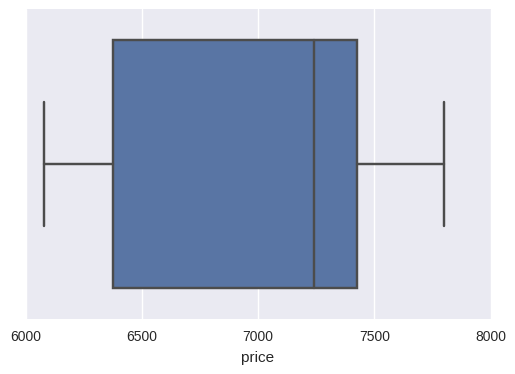

In [4]:
sns.boxplot(df.price)

In [5]:
mad = mad_outlier(df.price.values.reshape(-1, 1))
df.loc[mad]

,amount,price,dollar_volume,volume
dates,,,,


In [6]:
n_ticks = df.shape[0]
volume_ratio = df.volume.sum() / n_ticks
dollar_volume_ratio = df.dollar_volume.sum() / n_ticks

print(volume_ratio)
print(dollar_volume_ratio)

-0.0113178328244
-77.7484478463


In [7]:
tick_M = 281
tidx = tick_bars(df, 'price', tick_M)

tidx[:10]
df.iloc[tidx].shape, df.shape

tick_df = tick_bar_df(df, 'price', tick_M)
tick_df.shape

100%|██████████| 562899/562899 [00:00<00:00, 3120404.12it/s]


(2003, 4)

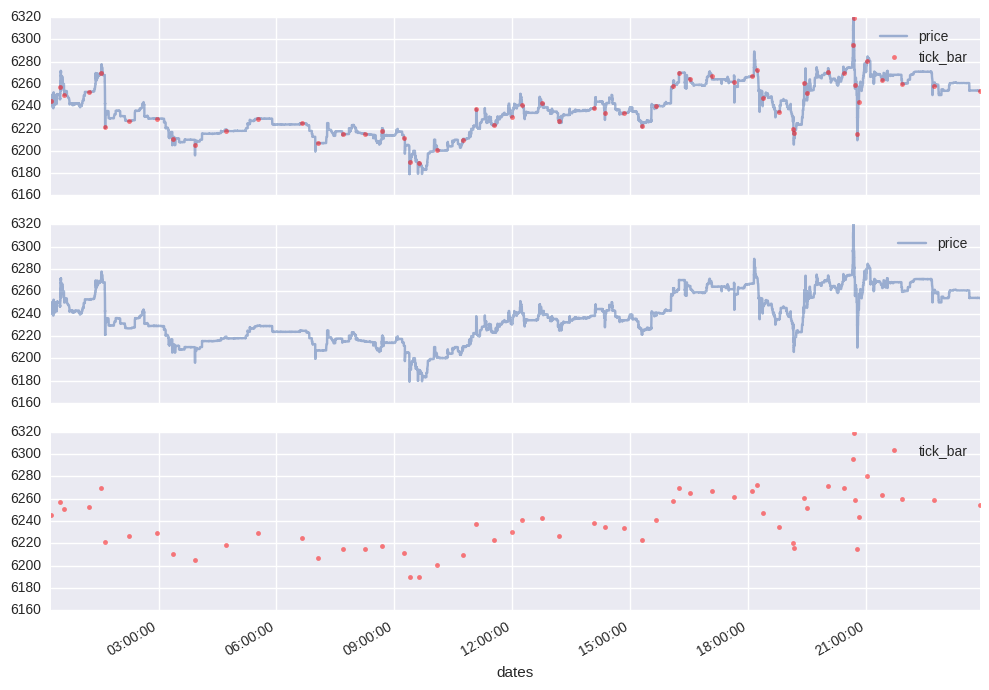

In [8]:
xDate = '2018-07-14'
xdf, xtdf = select_sample_data(df, tick_df, 'price', xDate)

xdf.shape, xtdf.shape

plot_sample_data(xdf, xtdf, 'tick_bar', alpha=0.5, markersize=7)

In [10]:
volume_M = 148
vidx = volume_bars(df, 'volume', volume_M)

vidx[:10]
df.iloc[vidx].shape, df.shape

volume_df = volume_bar_df(df, 'volume', volume_M)
volume_df.shape

100%|██████████| 562899/562899 [00:00<00:00, 2510241.01it/s]


(2009, 4)

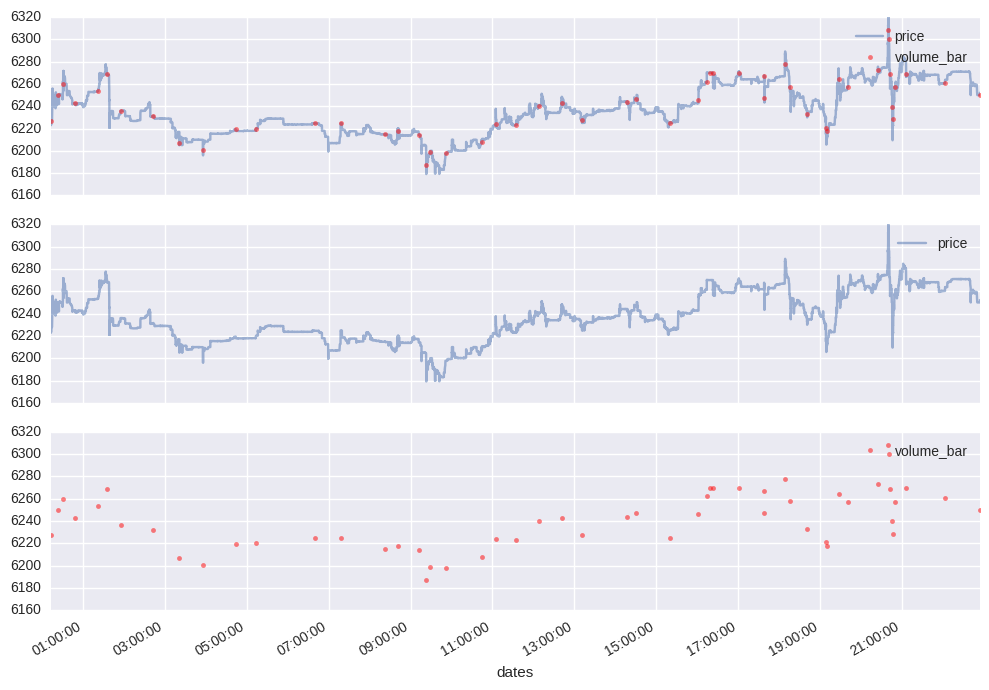

In [11]:
vDate = '2018-07-14'
vdf, vtdf = select_sample_data(df, volume_df, 'price', vDate)

vdf.shape, vtdf.shape

plot_sample_data(vdf, vtdf, 'volume_bar', alpha=0.5, markersize=7)

In [12]:
dollar_M = 3000000
dollar_df = dollar_bar_df(df, 'dollar_volume', dollar_M)
cprintf(dollar_df)


100%|██████████| 562899/562899 [00:00<00:00, 2424366.72it/s]47303/562899 [00:00<00:00, 2472342.70it/s]

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                       amount   price  dollar_volume    volume
dates                                                         
2018-07-23 12:57:57  0.500000  7712.4    3856.200000  0.500000
2018-07-23 13:24:42  0.155000  7715.3    1195.871500  0.155000
2018-07-23 14:18:39 -0.500000  7707.7   -3853.850000 -0.500000
2018-07-23 14:56:24 -0.077300  7701.8    -595.349140 -0.077300
2018-07-23 15:31:40  0.917507  7719.0    7082.239466  0.917507
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2018-07-08 22:27:05 to 2018-07-23 15:31:40
Data columns (total 4 columns):
amount           701 non-null float64
price            701 non-null float64
dollar_volume    701 non-null float64
volume           701 non-null float64
dtypes: float64(4)
memory usage:

(17,)


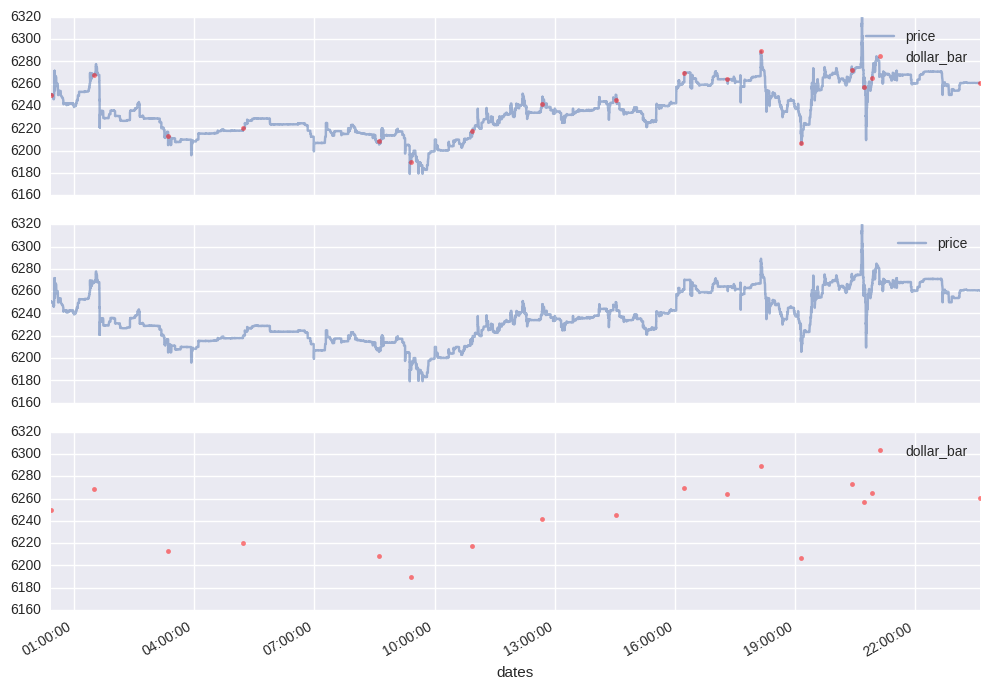

In [13]:
dDate = '2018-07-14'
ddf, dtdf = select_sample_data(df, dollar_df, 'price', dDate)

print(dtdf.shape)

plot_sample_data(ddf, dtdf, 'dollar_bar', alpha=0.5, markersize=7)

In [14]:
dollar_df.to_csv('data/dollar_bars.csv')

financial_data_structures.py:93: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  return df.groupby(pd.TimeGrouper('1d'))[price_col].count()


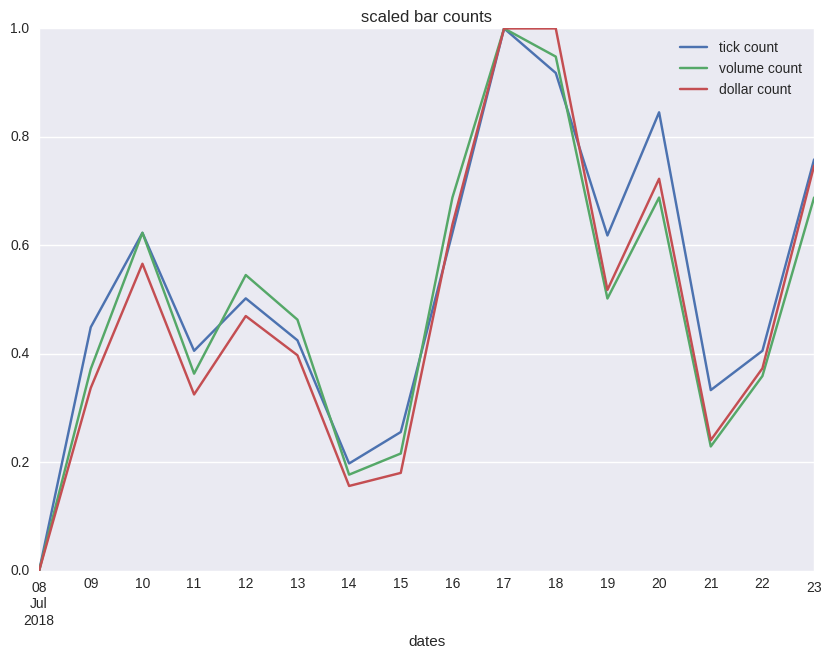

In [15]:
tc = scale(count_bars(tick_df))
vc = scale(count_bars(volume_df))
dc = scale(count_bars(dollar_df))

f,ax = plt.subplots(figsize=(10,7))

tc.plot(ax=ax, ls='-', label='tick count')
vc.plot(ax=ax, ls='-', label='volume count')
dc.plot(ax=ax, ls='-', label='dollar count')

ax.set_title('scaled bar counts')
ax.legend()

In [16]:
tr     = returns(tick_df.price)
vr     = returns(volume_df.price)
dr     = returns(dollar_df.price)
df_ret = returns(df.price)

bar_types = ['tick', 'volume', 'dollar', 'df']
bar_returns = [tr, vr, dr, df_ret]

In [17]:
get_test_stats(bar_types, bar_returns, jb)

,sample_size,{test_func.__name__}_stat
df,562898.0,3.352806e+10
dollar,700.0,4.599948e+01
tick,2002.0,8.563981e+02
volume,2008.0,6.225024e+02


In [18]:
get_test_stats(bar_types, bar_returns, shapiro)

/usr/local/lib/python2.7/dist-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,sample_size,{test_func.__name__}_stat
df,562898.0,0.375869
dollar,700.0,0.983940
tick,2002.0,0.973850
volume,2008.0,0.976670


In [19]:
dimbidx = get_imbalance(df.price.values) * np.abs(df.dollar_volume.iloc[1:])
cprintf(dimbidx)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     dollar_volume
dates                             
2018-07-23 15:47:49      -154.6440
2018-07-23 15:48:01         0.0000
2018-07-23 15:48:02         0.0000
2018-07-23 15:48:03         0.0000
2018-07-23 15:48:06       -38.6605
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 562898 entries, 2018-07-08 19:10:16 to 2018-07-23 15:48:06
Data columns (total 1 columns):
dollar_volume    562898 non-null float64
dtypes: float64(1)
memory usage: 8.6 MB
None
-------------------------------------------------------------------------------


In [22]:
wndo = dimbidx.shape[0] // 1000
E_bs = dimbidx.ewm(wndo).mean()

E_T = pd.Series(range(dimbidx.shape[0]), index = dimbidx.index).ewm(wndo).mean()

df0 = (pd.DataFrame().assign(bs=dimbidx).assign(E_T=E_T).assign(E_bs=E_bs).assign(absMul=lambda df: df.E_T * np.abs(df.E_bs)).assign(absTheta=dimbidx.cumsum().abs()))
cprintf(df0)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                           bs       E_T        E_bs        absMul  \
dates                                                               
2018-07-23 15:47:49 -154.6440  562331.0 -432.641668  2.432878e+08   
2018-07-23 15:48:01    0.0000  562332.0 -431.873211  2.428561e+08   
2018-07-23 15:48:02    0.0000  562333.0 -431.106118  2.424252e+08   
2018-07-23 15:48:03    0.0000  562334.0 -430.340388  2.419950e+08   
2018-07-23 15:48:06  -38.6605  562335.0 -429.644686  2.416042e+08   

                         absTheta  
dates                              
2018-07-23 15:47:49  1.145840e+07  
2018-07-23 15:48:01  1.145840e+07  
2018-07-23 15:48:02  1.145840e+07  
2018-07-23 15:48:03  1.145840e+07  
2018-07-23 15:48:06  1.145844e+07  
--------------------------------------------------
<class 'pandas.core.frame.Data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7eff19842fd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7eff19623d10>], dtype=object)

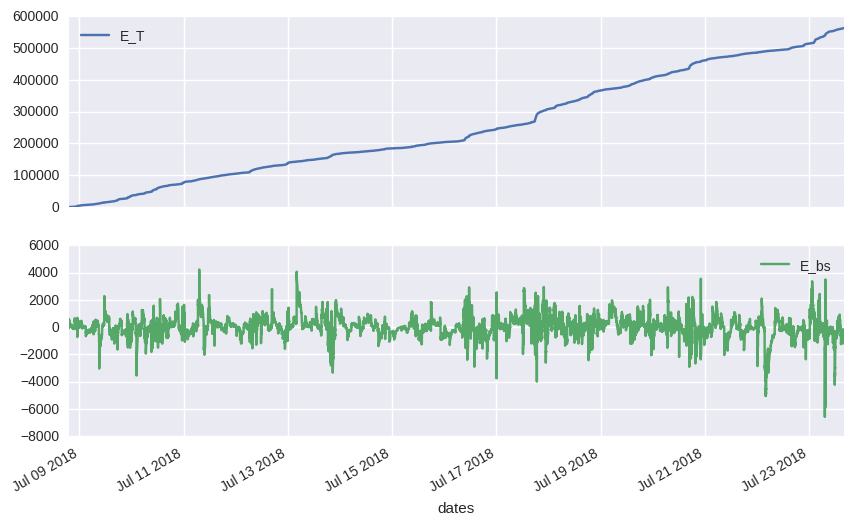

In [23]:
df0[['E_T', 'E_bs']].plot(subplots=True, figsize=(10,6))

In [24]:
df0.describe()/1000

,bs,E_T,E_bs,absMul,absTheta
count,562.898000,562.898000,562.898000,5.628980e+02,562.898000
mean,-0.020356,280.887424,-0.019751,1.726437e+05,9727.619290
std,11.460358,162.493205,0.811234,2.394189e+05,7410.298468
min,-2333.100000,0.000000,-6.586999,0.000000e+00,0.000000
25%,-0.019359,140.162250,-0.415639,2.809427e+04,2602.019301
50%,0.000000,280.886500,-0.012701,9.401148e+04,8383.904274
75%,0.013295,421.610750,0.410433,2.321033e+05,15037.485454
max,1897.956572,562.335000,4.220388,3.550853e+06,25497.686610


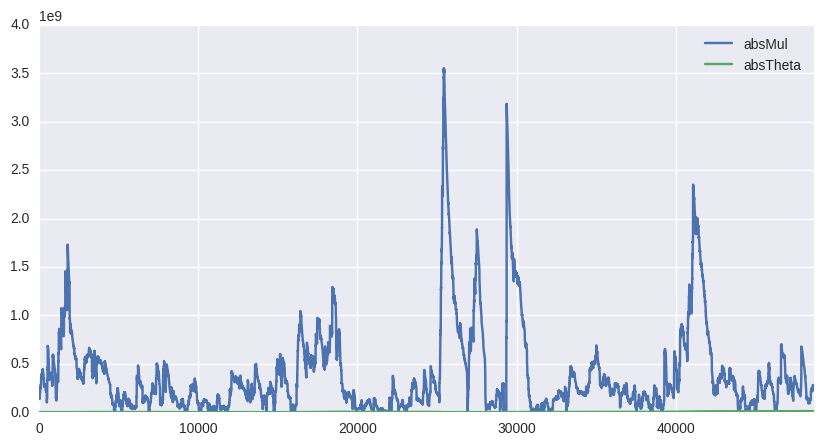

In [25]:
(df0.loc['2018-07-23', ['absMul','absTheta']].reset_index(drop=True).plot(figsize=(10,5)))

In [26]:
bars = agg_imbalance_bars(df0)
test_imb_bars = (pd.DataFrame(bars, columns=['start', 'stop', 'Ts']).drop_duplicates())
cprintf(test_imb_bars)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     start                stop  Ts
560953 2018-07-23 15:47:36 2018-07-23 15:47:49   2
560954 2018-07-23 15:47:49 2018-07-23 15:48:01   2
560955 2018-07-23 15:48:01 2018-07-23 15:48:02   2
560956 2018-07-23 15:48:02 2018-07-23 15:48:03   2
560957 2018-07-23 15:48:03 2018-07-23 15:48:06   2
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 293626 entries, 0 to 560957
Data columns (total 3 columns):
start    293626 non-null datetime64[ns]
stop     293626 non-null datetime64[ns]
Ts       293626 non-null int64
dtypes: datetime64[ns](2), int64(1)
memory usage: 9.0 MB
None
-------------------------------------------------------------------------------


In [27]:
test_imb_bars.Ts.describe().round()

count    293626.0
mean          5.0
std           9.0
min           2.0
25%           2.0
50%           3.0
75%           5.0
max        2030.0
Name: Ts, dtype: float64

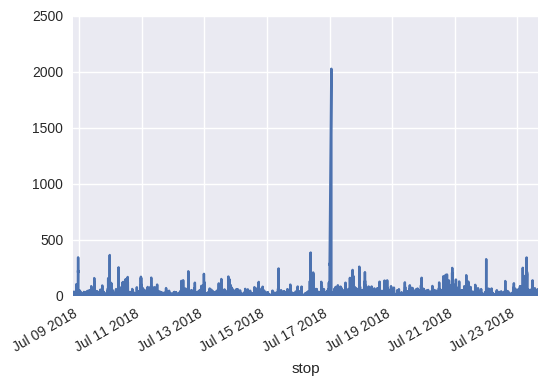

In [28]:
test_imb_bars.set_index('stop')['Ts'].plot()

In [29]:
dimbbars = df.price.loc[test_imb_bars.stop].drop_duplicates()
cprintf(dimbbars)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                           price
dates                           
2018-07-23 15:45:25  7728.291211
2018-07-23 15:46:01  7726.886450
2018-07-23 15:46:42  7728.525338
2018-07-23 15:46:43  7728.700000
2018-07-23 15:46:55  7729.695972
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38046 entries, 2018-07-08 19:10:16 to 2018-07-23 15:46:55
Data columns (total 1 columns):
price    38046 non-null float64
dtypes: float64(1)
memory usage: 594.5 KB
None
-------------------------------------------------------------------------------


In [30]:
dbars = dollar_df.price
cprintf(dbars)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                      price
dates                      
2018-07-23 12:57:57  7712.4
2018-07-23 13:24:42  7715.3
2018-07-23 14:18:39  7707.7
2018-07-23 14:56:24  7701.8
2018-07-23 15:31:40  7719.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2018-07-08 22:27:05 to 2018-07-23 15:31:40
Data columns (total 1 columns):
price    701 non-null float64
dtypes: float64(1)
memory usage: 31.0 KB
None
-------------------------------------------------------------------------------


In [31]:
dr = returns(dbars)
drimb = returns(dimbbars)

print(dr.shape)
print(drimb.shape)

(700,)
(38045,)


In [32]:
bar_types0 = ['dollar', 'dollar imbalance']
bar_rets0 = [dr, drimb]

In [33]:
get_test_stats(bar_types0, bar_rets0, jb)

,sample_size,{test_func.__name__}_stat
dollar,700.0,4.599948e+01
dollar imbalance,38045.0,6.296563e+06


In [34]:
get_test_stats(bar_types0, bar_rets0, shapiro)

,sample_size,{test_func.__name__}_stat
dollar,700.0,0.983940
dollar imbalance,38045.0,0.738339
